In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from torchvision.transforms import Compose, ToTensor, Resize
from sklearn.model_selection import train_test_split
import numpy as np
from numpy import asarray
from PIL import Image
import pathlib
import os
import time
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, f1_score
from torchvision.transforms import Resize, CenterCrop, ToTensor, Normalize
from google.colab import drive
import pathlib


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# device = "mps" if torch.backends.mps.is_available() else "cpu"

In [ ]:
# Hyper-parameters
num_epochs = 20
batch_size = 32
learning_rate = 0.01

#Model Parameters
num_features = 11

In [ ]:
drive.mount("/content/drive", force_remount=True)
dataset_url='/content/drive/MyDrive/plant_leaf_dataset/dataset2/'

Mounted at /content/drive


In [ ]:
# dataset = ImageFolder("/content/drive/MyDrive/plant_leaf_dataset/dataset2", transform=Compose([ToTensor(), Resize((229, 229)),CenterCrop(299),oTensor(),Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ]))
dataset = ImageFolder(dataset_url, transform=transforms.Compose([Resize((229, 229)),CenterCrop(299),ToTensor(),Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ]))
# dataset = torch.utils.data.random_split(dataset, [100, len(dataset) - 100])
dataset, testDataset=torch.utils.data.random_split(dataset, [int(0.9 * len(dataset)), len(dataset) - (int(0.9 * len(dataset)))])
trainDataset, validationDataset = torch.utils.data.random_split(dataset, [int(0.9 * len(dataset)), len(dataset) - (int(0.9 * len(dataset)))])

trainingDataLoader = DataLoader(
    trainDataset,
    batch_size=batch_size,
    shuffle=True
)

validationDataLoader = DataLoader(
    validationDataset,
    batch_size=batch_size,
    shuffle=False
)

testingDataLoader = DataLoader(
    testDataset,
    batch_size=batch_size,
    shuffle=False
)

print(len(dataset))
print(len(trainingDataLoader))
print(len(validationDataLoader))
print(len(testingDataLoader))

#Write code to display the images in each dataloader

2049
58
7
8


In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_features)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

print(model)

In [ ]:
print(device)

cuda


In [ ]:
total_steps = len(trainingDataLoader)

batchwiseTrainAccuracyLog = []
batchwiseTrainLossLog = []

epochwiseTrainAccuracyLog = []
epochwiseTrainLossLog = []

batchwiseValAccuracyLog = []
batchwiseValLossLog = []

epochwiseValAccuracyLog = []
epochwiseValLossLog = []

for epoch in range(num_epochs):

    total_label_count = 0

    accumulated_train_loss=0
    accumulated_validation_loss=0

    accumulated_train_accuracy=0
    accumulated_validation_accuracy=0

    inner_loop_counter_train=0
    model.train()
    for i, data in enumerate(trainingDataLoader):
        inner_loop_counter_train+=1

        images, labels = data[0].to(device), data[1].to(device)
        # Forward pass
        outputs = model(images)
        outputs = outputs.logits
        loss = criterion(outputs, labels)
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total = labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        total_label_count += labels.size(0)
        accumulated_train_accuracy += (predicted == labels).sum().item()
        accumulated_train_loss+=loss.item()
        if (i + 1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.7f}, Accuracy: {:.4f}%'
                .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(),
                    (correct / total) * 100))
            batchwiseTrainAccuracyLog.append((correct / total) * 100)
            batchwiseTrainLossLog.append(loss.item())
    training_accuracy = correct / total
    epochwiseTrainAccuracyLog.append(training_accuracy)
    print(f'EPOCH {epoch + 1}.....................')
    print('Accuracy on training set: {}%'.format(100 * training_accuracy))
    epochwiseTrainLossLog.append(accumulated_train_loss/inner_loop_counter_train)

    #Evaluation using validation data

    total_label_count = 0

    inner_loop_counter_validation=0

    model.eval()
    with torch.no_grad():
      for i, data in enumerate(trainingDataLoader):
        inner_loop_counter_validation+=1

        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total = labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        accumulated_validation_accuracy += (predicted == labels).sum().item()
        total_label_count += labels.size(0)
        accumulated_validation_loss+=loss.item()
        if (i + 1) % 10 == 0:
            batchwiseValAccuracyLog.append((correct / total) * 100)
            batchwiseValLossLog.append(loss.item())
    validation_accuracy = accumulated_validation_accuracy / total_label_count
    epochwiseValAccuracyLog.append(validation_accuracy)
    print('Accuracy on validation set: {}%'.format(100 * validation_accuracy))
    epochwiseValLossLog.append(accumulated_validation_loss/inner_loop_counter_validation)
print("Training Finished!")


Epoch [1/20], Step [10/58], Loss: 2.2381933, Accuracy: 21.8750%
Epoch [1/20], Step [20/58], Loss: 2.3518715, Accuracy: 18.7500%
Epoch [1/20], Step [30/58], Loss: 2.2406981, Accuracy: 15.6250%
Epoch [1/20], Step [40/58], Loss: 2.1445758, Accuracy: 25.0000%
Epoch [1/20], Step [50/58], Loss: 1.9330342, Accuracy: 37.5000%
EPOCH 1.....................
Accuracy on training set: 15.0%
Accuracy on validation set: 27.2234273318872%
Epoch [2/20], Step [10/58], Loss: 2.0918097, Accuracy: 21.8750%
Epoch [2/20], Step [20/58], Loss: 2.0710363, Accuracy: 18.7500%
Epoch [2/20], Step [30/58], Loss: 2.0244308, Accuracy: 34.3750%
Epoch [2/20], Step [40/58], Loss: 1.9607991, Accuracy: 34.3750%
Epoch [2/20], Step [50/58], Loss: 2.0363245, Accuracy: 34.3750%
EPOCH 2.....................
Accuracy on training set: 25.0%
Accuracy on validation set: 26.46420824295011%
Epoch [3/20], Step [10/58], Loss: 1.9455378, Accuracy: 31.2500%
Epoch [3/20], Step [20/58], Loss: 1.8418202, Accuracy: 31.2500%
Epoch [3/20], Ste

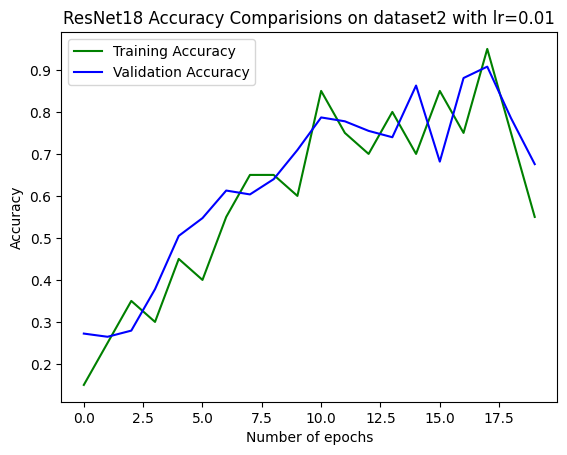

In [ ]:
fig,ax=plt.subplots()
epochs_list = list(range(0,20))
ax.plot(epochs_list,epochwiseTrainAccuracyLog,'g',label='Training Accuracy')
ax.plot(epochs_list,epochwiseValAccuracyLog,'b',label='Validation Accuracy')
ax.plot()
ax.set_title('ResNet18 Accuracy Comparisions on dataset2 with lr=0.01')
ax.set_xlabel('Number of epochs')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

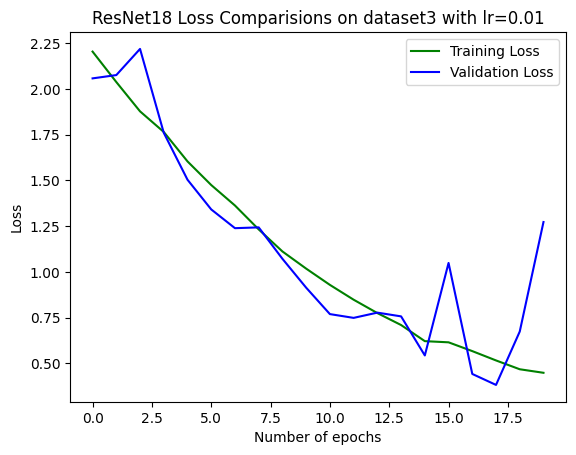

In [ ]:
fig,ax=plt.subplots()
ax.plot(epochs_list,epochwiseTrainLossLog,'g',label='Training Loss')
ax.plot(epochs_list,epochwiseValLossLog,'b',label='Validation Loss')
ax.plot()
ax.set_title('ResNet18 Loss Comparisions on dataset3 with lr=0.01')
ax.set_xlabel('Number of epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

In [ ]:
y_pred = []
groundtruth = []

model.eval()

testAccuracyLog = []
testLossLog = []

with torch.no_grad():

    inner_loop_counter_test = 0

    accumulated_test_accuracy=0
    accumulated_test_loss=0

    for images, labels in testingDataLoader:
        images = images.to(device)
        labels = labels.to(device)
        inner_loop_counter_test+=1
        test_loss=0
        outputs = model(images)
        test_loss=criterion(outputs,labels)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_pred.append(predicted)
        groundtruth.append(labels)
        accumulated_test_loss+=test_loss.item()
    testLossLog.append(accumulated_test_loss/inner_loop_counter_test)
    test_accuracy=correct/total
    print('Accuracy on test set: {}%'.format(100 * test_accuracy))
    testAccuracyLog.append(test_accuracy)

predictions_np = [tensor.detach().cpu().numpy() for tensor in y_pred]
ground_truth_np = [tensor.detach().cpu().numpy() for tensor in groundtruth]

predictions_np = np.concatenate(predictions_np)
ground_truth_np = np.concatenate(ground_truth_np)

accuracy = accuracy_score(ground_truth_np, predictions_np)
recall = recall_score(ground_truth_np, predictions_np, average='weighted')
conf_matrix = confusion_matrix(ground_truth_np, predictions_np)
f_score = f1_score(ground_truth_np, predictions_np, average='weighted')

print("Dataset 2 - Test Metrics\nAccuracy:", accuracy*100)
print("Recall:", recall*100)
print("F-score:", f_score*100)

print("Confusion Matrix:")

plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues',cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix ResNet18 on Dataset2 lr=0.01')
plt.show()

Accuracy on test set: 67.74193548387096%
Dataset 2 - Test Metrics
Accuracy: 68.42105263157895
Recall: 68.42105263157895
F-score: 66.81854216398459
Confusion Matrix:


NameError: name 'sns' is not defined

<Figure size 1000x800 with 0 Axes>